In [1]:
import os
from glob import glob
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from numpy.core.defchararray import find
from pandas.api.types import CategoricalDtype
from scipy import stats
from sklearn import linear_model, preprocessing
from sklearn.metrics import (RocCurveDisplay, auc, confusion_matrix,
                             mean_squared_error, roc_curve)
from sklearn.model_selection import KFold, RandomizedSearchCV, train_test_split
from sklearn.svm import SVC
from sklearn.utils.fixes import loguniform

from label_flip_revised.simple_nn_model import SimpleModel
from label_flip_revised.torch_utils import evaluate, train_model
from label_flip_revised.utils import create_dir, open_csv


In [2]:
PATH_ROOT = Path(os.getcwd()).absolute().parent
print(PATH_ROOT)

/home/lukec/workspace/label_flip_revised


In [3]:
plt.rcParams["font.size"] = 14

In [4]:
DATANAMES = [
    'abalone',
    'australian',
    'banknote',
    'breastcancer',
    'cmc',
    'htru2',
    'phoneme',
    'ringnorm',
    'texture',
    'yeast'
]

In [5]:
df_cm_nn = pd.read_csv(os.path.join(PATH_ROOT, 'results', 'real_cmeasures_nn.csv'))
df_cm_svm = pd.read_csv(os.path.join(PATH_ROOT, 'results', 'real_cmeasures_svm.csv'))
df_cm_nn_rand = pd.read_csv(os.path.join(PATH_ROOT, 'results', 'real_cmeasures_rand_nn.csv'))
df_cm_svm_rand = pd.read_csv(os.path.join(PATH_ROOT, 'results', 'real_cmeasures_rand_svm.csv'))

In [6]:
df_cm_nn.columns

Index(['Data', 'Filepath', 'Rate', 'F1', 'F1 SD', 'F1v', 'F2', 'F3', 'F4',
       'N1', 'N2', 'N2 SD', 'N3 ', 'N3 SD', 'N4', 'N4 SD', 'T1', 'T1 SD',
       'LSC', 'L1', 'L2', 'L3', 'T2', 'T3', 'T4', 'C1', 'C2', 'Density',
       'ClsCoef', 'Hubs', 'HubsSD', 'Train', 'Test'],
      dtype='object')

In [7]:
df_cm_svm.columns

Index(['Data', 'Filepath', 'Rate', 'F1', 'F1 SD', 'F1v', 'F2', 'F3', 'F4',
       'N1', 'N2', 'N2 SD', 'N3 ', 'N3 SD', 'N4', 'N4 SD', 'T1', 'T1 SD',
       'LSC', 'L1', 'L2', 'L3', 'T2', 'T3', 'T4', 'C1', 'C2', 'Density',
       'ClsCoef', 'Hubs', 'HubsSD', 'Train', 'Test'],
      dtype='object')

In [8]:
col_X = [
    'F1', 'F1 SD', 'F1v', 'F2', 'F3', 'F4',
    'N1', 'N2', 'N2 SD', 'N3 ', 'N3 SD', 'N4', 'N4 SD', 'T1', 'T1 SD',
    'LSC', 'L1', 'L2', 'L3', 'T2', 'T3', 'T4', 'C1', 'C2', 'Density',
    'ClsCoef', 'Hubs', 'HubsSD'
]
col_y = 'Test'

In [9]:
N_ITER_SEARCH = 100

regressor = linear_model.Ridge()
param = {'alpha': loguniform(1e-4, 10),}
param_search = RandomizedSearchCV(regressor, param_distributions=param, n_iter=N_ITER_SEARCH, n_jobs=-1)
param_search.fit(df_cm_nn[col_X], df_cm_nn[col_y])

best_param = param_search.best_estimator_.get_params()
print('Best params:')
print(best_param)

Best params:
{'alpha': 0.24866040360927283, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': 'deprecated', 'positive': False, 'random_state': None, 'solver': 'auto', 'tol': 0.001}


In [10]:
alpha = 0.25

In [11]:
predictions_nn = []
predictions_svm = []
predictions_rand = []

for data_test in DATANAMES:
    df_train_1 = df_cm_nn[df_cm_nn['Data'] != data_test]
    df_train_2 = df_cm_nn_rand[df_cm_nn_rand['Data'] != data_test]

    df_test_nn = df_cm_nn[df_cm_nn['Data'] == data_test]
    df_test_svm = df_cm_svm[df_cm_svm['Data'] == data_test]
    df_test_rand = df_cm_nn_rand[df_cm_nn_rand['Data'] == data_test]
    
    df_train = pd.concat([df_train_1, df_train_2], ignore_index=True)
    X_train = df_train[col_X]
    y_train = df_train[col_y]

    regressor = linear_model.Ridge(alpha=alpha)
    regressor.fit(X_train, y_train)

    X_test_nn = df_test_nn[col_X]
    X_test_svm = df_test_svm[col_X]
    X_test_rand = df_test_rand[col_X]

    pred = regressor.predict(X_test_nn)
    predictions_nn += pred.tolist()

    pred = regressor.predict(X_test_svm)
    predictions_svm += pred.tolist()

    pred = regressor.predict(X_test_rand)
    predictions_rand += pred.tolist()

In [12]:
def get_err(pred, y_true):
    abs_err = np.abs(y_true - pred)
    rmse = np.sqrt(mean_squared_error(y_true, pred))
    return abs_err, rmse

abs_err_nn, rmse = get_err(predictions_nn, df_cm_nn['Test'].to_numpy())
print(f'[NN] RMSE test: {rmse:.3f}')

abs_err_svm, rmse = get_err(predictions_svm, df_cm_svm['Test'].to_numpy())
print(f'[SVM] RMSE test: {rmse:.3f}')

abs_err_rand, rmse = get_err(predictions_rand, df_cm_nn_rand['Test'].to_numpy())
print(f'[RAND] RMSE test: {rmse:.3f}')

[NN] RMSE test: 0.141
[SVM] RMSE test: 0.146
[RAND] RMSE test: 0.121


In [17]:
THRESHOLD = 0.05

df_pred = pd.DataFrame({
    'Rate': df_cm_nn['Rate'],
    'NN-FALFA': predictions_nn,
    'SVM-ALFA': predictions_svm,
    'NN-Rand': predictions_nn
})
df_train = pd.DataFrame({
    'Rate': df_cm_nn['Rate'],
    'NN-FALFA': df_cm_nn['Train'],
    'SVM-ALFA': df_cm_svm['Train'],
    'NN-Rand': df_cm_nn_rand['Train']
})
df_pred.to_csv(os.path.join(PATH_ROOT, 'results', 'real_pred_test.csv'))
df_train.to_csv(os.path.join(PATH_ROOT, 'results', 'real_train.csv'))

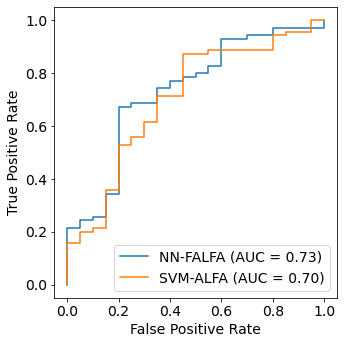

In [22]:
FIGSIZE = (5, 5)
NAMES = [
    'NN-FALFA',
    'SVM-ALFA',
    # 'NN-Rand',
]

fig, ax = plt.subplots(figsize=FIGSIZE)
for col in NAMES:
    y_true = (df_pred['Rate'].to_numpy() > THRESHOLD).astype(int)
    y_score = (df_train[col] - df_pred[col]).to_numpy()
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot(ax=ax, name=col)
plt.tight_layout()
path_output = os.path.join(PATH_ROOT, 'results', 'roc_real.pdf')
plt.savefig(path_output, dpi=300)